In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import GPy
from matplotlib.backends.backend_pdf import PdfPages
import functools as ft
%matplotlib inline
sns.set_style("darkgrid")
import matplotlib

matplotlib.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 15


def f(x):
    return -(x + x * np.sin(2 * x))


def pi(mu, var, best):
    return norm.cdf((best - mu) / np.sqrt(var))


def ei(mu, var, best):
    z = (best - mu) / np.sqrt(var)
    return (best - mu) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)


def lcb(mu, var, beta):
    return -(mu - beta * np.sqrt(var))


def mes(mu, var, k: int = 10, min: bool = False):
    if min:
        mu = -mu
    dev = np.sqrt(var)

    r = np.random.rand(k)
    r1, r2 = 0.25, 0.75

    def ymax_cdf(z):
        gamma_z = (z - mu) / dev
        # print(mu)
        # print(gamma_z)
        # print(np.prod(norm.cdf(gamma_z)))
        return np.prod(norm.cdf(gamma_z))

    init_x = np.mean(mu)
    y1 = binary_search(r1, init_x, ymax_cdf, eps=0.001)
    y2 = binary_search(r2, init_x, ymax_cdf, eps=0.001)
    # print("y1:{}, y2:{}".format(y1, y2))

    old_set = np.seterr(divide="raise")
    a, b = np.linalg.solve(
        np.array([[1, -np.log(-np.log(r1))], [1, -np.log(-np.log(r2))]]),
        np.array([y1, y2]),
    )
    # print("a:{}, b:{}".format(a, b))

    y_max = a - b * np.log(-np.log(r))
    # print("ymax:\n{}".format(y_max))
    gamma = (y_max[:, None] - mu) / dev
    gamma_cdf = np.maximum(1e-6, norm.cdf(gamma))
    try:
        result = np.mean(
            gamma * norm.pdf(gamma) / (2 * gamma_cdf) - np.log(gamma_cdf), axis=0
        )
        return result
    except FloatingPointError as e:
        lit = gamma_cdf[gamma_cdf < 0.1]
        print(lit)
        e.with_traceback()


def binary_search(target, init_x, f, eps=0.001):
    lower = -np.inf
    upper = np.inf
    x = init_x

    while True:
        value = f(x)
        if np.abs(target - value) <= eps:
            return x
        elif value < target:
            lower = x
            if upper == np.inf:
                x += np.abs(x + 1) * 10
            else:
                x = (upper + lower) / 2
        else:
            upper = x
            if lower == -np.inf:
                x -= np.abs(x + 1) * 10
            else:
                x = (upper + lower) / 2

nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize

Name : GP regression
Objective : -5.908655190937109
Number of Parameters : 3
Number of Optimization Parameters : 0
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    6.0  |   +ve fixed   |        
  rbf.lengthscale          |    0.6  |   +ve fixed   |        
  Gaussian_noise.variance  |  1e-06  |   +ve fixed   |        


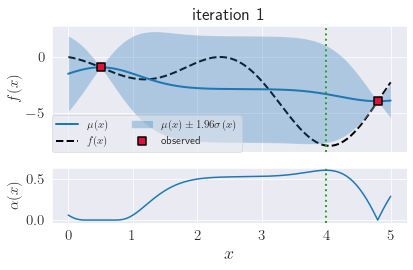

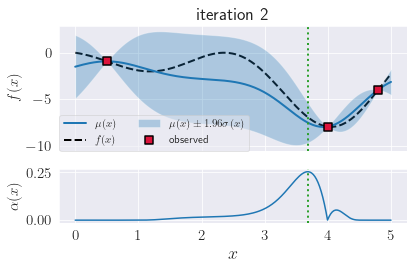

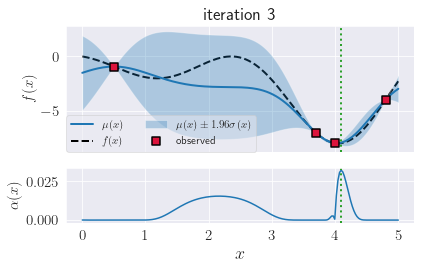

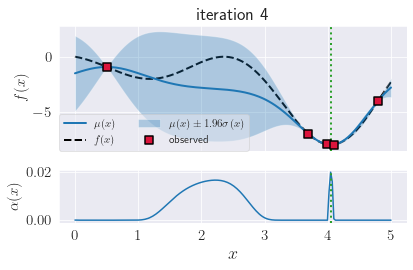

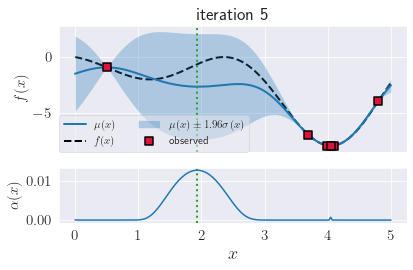

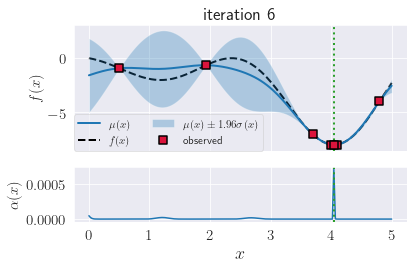

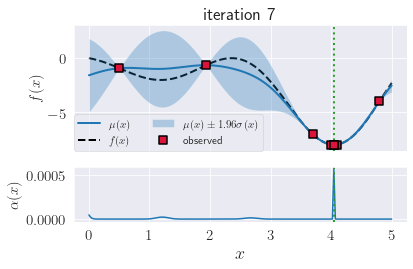

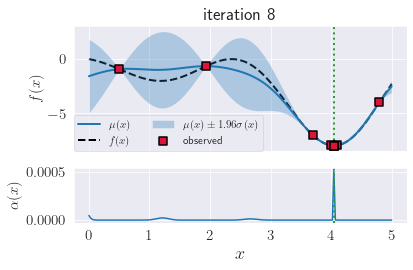

In [3]:
np.random.seed(0)
x = np.linspace(0, 5, 200).reshape(-1, 1)
y = f(x)

obs_x = []
obs_y = []
obs_i = []


pdf = PdfPages("bo.pdf")

q = [20, 191]
c_best = np.min(y[q])

for item in q:
    obs_x.append(x[item])
    obs_y.append(y[item])
    obs_i.append(item)


for i in range(8):
    m = np.mean(y)
    gp = GPy.models.GPRegression(np.array(obs_x), np.array(obs_y) - m)
    gp.Gaussian_noise.constrain_fixed(1e-6)
    gp.rbf.variance.constrain_fixed(6)
    gp.rbf.lengthscale.constrain_fixed(0.6)
    gp.optimize()
    # print(gp)

    mean, var = gp.predict(x)
    mean += m
    mean = mean.flatten()
    var = var.flatten()
    ci = 1.96 * np.sqrt(var)

    fig = plt.figure()
    gs = plt.GridSpec(3, 1)
    ax = [fig.add_subplot(gs[0:2, 0]), fig.add_subplot(gs[2, 0])]
    ax[0].plot(x.flatten(), mean, label=r"$\mu(x)$", zorder=2, lw=2)
    ax[0].fill_between(
        x.flatten(),
        mean - ci,
        mean + ci,
        label=r"$\mu(x)\pm 1.96\sigma(x)$",
        alpha=0.3,
        zorder=2,
    )
    ax[0].plot(
        x.flatten(), y.flatten(), c="black", ls="--", label=r"$f(x)$", zorder=1, lw=2
    )
    ax[0].scatter(
        np.array(obs_x),
        np.array(obs_y),
        marker="s",
        s=50,
        color="crimson",
        edgecolor="black",
        lw=1.5,
        zorder=3,
        label="observed",
    )

    # ax[0].set_xlabel("$x$", fontsize=18)
    ax[0].tick_params(labelbottom=False)
    ax[0].set_ylabel("$f(x)$")
    # ax[0].set_ylim(-10.5, 3)
    ax[0].legend(borderaxespad=0, ncol=2, framealpha=0.5, fontsize=11)
    ax[0].set_title("iteration {}".format(i + 1))
    # ax[0].axhline(c_best)

    # ac = pi(mean, var, c_best)
    ac = ei(mean, var, c_best)
    # ac = lcb(mean, var, beta=4)
    # ac = lcb(mean, var, beta=1)
    # ac = mes(mean, var, k=100, min=True)
    # ac[obs_i] = 0

    next_i = np.argmax(ac)

    ax[1].plot(x, ac)
    ax[0].axvline(x[next_i], ls=":", c="tab:green", lw=2)
    ax[1].axvline(x[next_i], ls=":", c="tab:green", lw=2)
    ax[1].set_xlabel("$x$", fontsize=18)
    ax[1].set_ylabel(r"$\alpha(x)$")

    fig.tight_layout()
    pdf.savefig(fig)
    fig.savefig(f'image/ei_{i+1}')
    obs_x.append(x[next_i])
    obs_y.append(y[next_i])
    obs_i.append(next_i)
    c_best = min(c_best, y[next_i])
    
print(gp)
pdf.close()

In [ ]:
np.random.seed(0)
x = np.linspace(0, 5, 200).reshape(-1, 1)
y = f(x)

obs_x = []
obs_y = []


pdf = PdfPages("compare_mes_g.pdf")

q = [20, 126, 191]
c_best = np.min(y[q])

for item in q:
    obs_x.append(x[item])
    obs_y.append(y[item])


for i in range(6):
    m = np.mean(y)
    gp = GPy.models.GPRegression(np.array(obs_x), np.array(obs_y) - m)
    gp.Gaussian_noise.constrain_fixed(1e-6)
    gp.rbf.variance.constrain_fixed(6)
    gp.rbf.lengthscale.constrain_fixed(0.6)
    gp.optimize()
    # print(gp)

    mean, var = gp.predict(x)
    mean += m
    mean = mean.flatten()
    var = var.flatten()
    ci = 1.96 * np.sqrt(var)

    fig = plt.figure()
    gs = plt.GridSpec(3, 1)
    ax = [fig.add_subplot(gs[0:2, 0]), fig.add_subplot(gs[2, 0])]
    ax[0].plot(x.flatten(), mean, label=r"$\mu(x)$", zorder=2, lw=2)
    ax[0].fill_between(
        x.flatten(),
        mean - ci,
        mean + ci,
        label=r"$\mu(x)\pm 1.96\sigma(x)$",
        alpha=0.3,
        zorder=2,
    )
    ax[0].plot(
        x.flatten(), y.flatten(), c="black", ls="--", label=r"$f(x)$", zorder=1, lw=2
    )
    ax[0].scatter(
        np.array(obs_x),
        np.array(obs_y),
        marker="s",
        s=50,
        color="crimson",
        edgecolor="black",
        lw=1.5,
        zorder=3,
        label="observed",
    )

    # ax[0].set_xlabel("$x$", fontsize=18)
    ax[0].tick_params(labelbottom=False)
    ax[0].set_ylabel("$f(x)$")
    # ax[0].set_ylim(-10.5, 3)
    ax[0].legend(borderaxespad=0, ncol=2, framealpha=0.5, fontsize=11)
    ax[0].set_title("iteration {}".format(i + 1))
    # ax[0].axhline(c_best)

    # ac = ei(mean, var, c_best)
    # ac = lcb(mean, var, beta=1)
    ac = mes(mean, var, k=1)
    sub_ac10 = mes(mean, var, k=10)
    sub_ac100 = mes(mean, var, k=100)

    next_i = np.argmax(ac)

    ax[1].plot(x, ac, label=r"$k=1$")
    ax[1].plot(x, sub_ac10, label=r"$k=10$")
    ax[1].plot(x, sub_ac100, label=r"$k=100$")
    ax[1].legend(fontsize=10)
    ax[0].axvline(x[next_i], ls=":", c="tab:green", lw=2)
    ax[1].axvline(x[next_i], ls=":", c="tab:green", lw=2)
    ax[1].set_xlabel("$x$", fontsize=18)
    ax[1].set_ylabel(r"$\alpha(x)$")

    fig.tight_layout()
    pdf.savefig(fig)
    obs_x.append(x[next_i])
    obs_y.append(y[next_i])
    c_best = min(c_best, y[next_i])

pdf.close()